In [25]:
using Plots
using HDF5
include("LiPoSID.jl")

Main.LiPoSID

In [51]:
function get_keys(df)
    h5open(df, "r") do file
        return keys(file)
    end
end

function get_rho_series(file_name, γ)
    h5open(file_name, "r") do file
        ρᵧ = read(file[string(γ)])
        t = ρᵧ["t"]
        ρ₀₀ = ρᵧ["p0"]; Re_ρ₀₁ = ρᵧ["s_re"];  Im_ρ₀₁ = ρᵧ["s_im"]
        ρ_series = []
        t_series = []

        for i in 1:length(t)
            ρᵢ= [ ρ₀₀[i]                      Re_ρ₀₁[i] + im * Im_ρ₀₁[i]
                  Re_ρ₀₁[i] - im * Im_ρ₀₁[i]  1 - ρ₀₀[i]                 ]
            push!(ρ_series, convert(Matrix{ComplexF64}, ρᵢ))
            push!(t_series, convert(Float64, t[i]))
        end
        return(ρ_series, t_series)
    end
end

function linearity_error(directory, γᵢ)
    dodeca_file_names = ["State_D"*string(n) for n=1:20]
    lin_err = []
    for df in dodeca_file_names

        ρᵉ, tᵉ = get_rho_series(directory*"State_B1_data.h5", string(γᵢ))
        ρᵍ, tᵍ = get_rho_series(directory*"State_B2_data.h5", string(γᵢ))
        ρˣ, tˣ = get_rho_series(directory*"State_B3_data.h5", string(γᵢ))
        ρʸ, tʸ = get_rho_series(directory*"State_B4_data.h5", string(γᵢ))

        lᵉ = size(ρᵉ, 1); lᵍ = size(ρᵍ, 1); lˣ = size(ρˣ, 1); lʸ = size(ρʸ, 1)

        ρᵞⁱ, tᵞⁱ = get_rho_series(directory*df*"_data.h5", string(γᵢ))

        lᵞⁱ = size(ρᵞⁱ, 1)

        kᵉ = ρᵞⁱ[1][1,1] - real(ρᵞⁱ[1][2,1]) + imag(ρᵞⁱ[1][2,1])
        kᵍ = ρᵞⁱ[1][2,2] - real(ρᵞⁱ[1][2,1]) + imag(ρᵞⁱ[1][2,1])
        kˣ =  2 * real(ρᵞⁱ[1][2,1])
        kʸ = -2 * imag(ρᵞⁱ[1][2,1])

        lᵉ = size(ρᵉ, 1); lᵍ = size(ρᵍ, 1); lˣ = size(ρˣ, 1); lʸ = size(ρʸ, 1)

        #= if !(lᵉ  == lᵍ == lˣ == lʸ)
            println("WARNING! BASE series of different length")
            println(size(ρᵉ), size(ρᵍ), size(ρˣ), size(ρʸ))
        end =#

        lᵐᵃˣ = min(lᵉ, lᵍ,  lˣ, lʸ, lᵞⁱ)
        ρᴸ = kᵉ * ρᵉ[1:lᵐᵃˣ] + kᵍ * ρᵍ[1:lᵐᵃˣ] + kˣ * ρˣ[1:lᵐᵃˣ] + kʸ * ρʸ[1:lᵐᵃˣ]

        push!(lin_err, abs.(LiPoSID.frobenius_norm2.(ρᵞⁱ[1:lᵐᵃˣ] - ρᴸ[1:lᵐᵃˣ])))

    end
    return lin_err
end


linearity_error (generic function with 1 method)

In [79]:
# Names of files with Kurt data
basis_file_names = ["State_B"*string(n) for n=1:4]
println(basis_file_names)
dodeca_file_names = ["State_D"*string(n) for n=1:20]
print(dodeca_file_names)
directory = "C:/Users/Zakhar/Documents/GitHub/JPOP_SID/DATA/"
#directory = "C:/Users/Zakhar/Documents/GitHub/Kurt2021/2022JAN24/DATA/"

["State_B1", "State_B2", "State_B3", "State_B4"]
["State_D1", "State_D2", "State_D3", "State_D4", "State_D5", "State_D6", "State_D7", "State_D8", "State_D9", "State_D10", "State_D11", "State_D12", "State_D13", "State_D14", "State_D15", "State_D16", "State_D17", "State_D18", "State_D19", "State_D20"]

"C:/Users/Zakhar/Documents/GitHub/JPOP_SID/DATA/"

    Check available coupling γ

In [4]:
γ = get_keys(directory*basis_file_names[1]*"_data.h5")

8-element Vector{String}:
 "0.079477"
 "0.25133"
 "0.79477"
 "2.5133"
 "25.133"
 "251.33"
 "7.9477"
 "79.477"

Check initial states

In [50]:
γᵢ = γ[1]
ρᵉ, tᵉ = get_rho_series(directory*"State_B1_data.h5", string(γᵢ)) # basis_file_names[1]
ρᵍ, tᵍ = get_rho_series(directory*"State_B2_data.h5", string(γᵢ)) # basis_file_names[2]
ρˣ, tˣ = get_rho_series(directory*"State_B3_data.h5", string(γᵢ)) # basis_file_names[3]
ρʸ, tʸ = get_rho_series(directory*"State_B4_data.h5", string(γᵢ)) # basis_file_names[4]
println("ρᵉ₀ = ", ρᵉ[1])
println("ρᵍ₀ = ", ρᵍ[1])
println("ρˣ₀ = ", ρˣ[1])
println("ρʸ₀ = ", ρʸ[1])

ρᵉ₀ = ComplexF64[1.0 + 0.0im 0.0 - 0.0im; 0.0 + 0.0im 0.0 + 0.0im]
ρᵍ₀ = ComplexF64[0.0 + 0.0im 0.0 - 0.0im; 0.0 + 0.0im 1.0 + 0.0im]
ρˣ₀ = ComplexF64[0.5 + 0.0im 0.5 - 0.0im; 0.5 + 0.0im 0.5 + 0.0im]
ρʸ₀ = ComplexF64[0.5 + 0.0im 0.0 + 0.5im; 0.0 - 0.5im 0.5 + 0.0im]


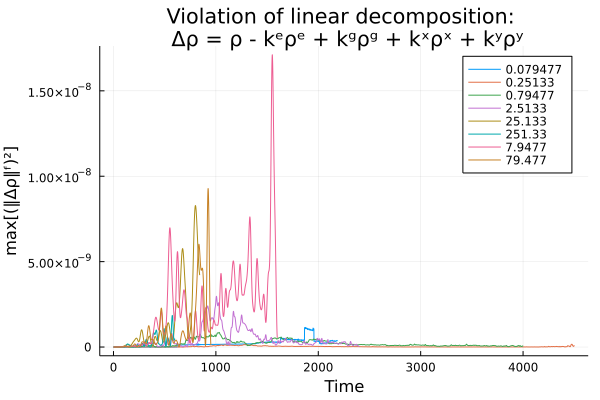

In [87]:
plt = plot(maximum(linearity_error(directory, γ[1]), dims=1), label = γ[1])
for γᵢ in γ[2:end]
    plt = plot!(maximum(linearity_error(directory, γᵢ), dims=1), label = γᵢ)
end
plt = xlabel!("Time")
plt = ylabel!("max[(‖Δρ‖ᶠ)²]")
plt = title!("Violation of linear decomposition: \n Δρ = ρ - kᵉρᵉ + kᵍρᵍ + kˣρˣ + kʸρʸ")
savefig(plt, "lin_err_all_gamma.png")
plt

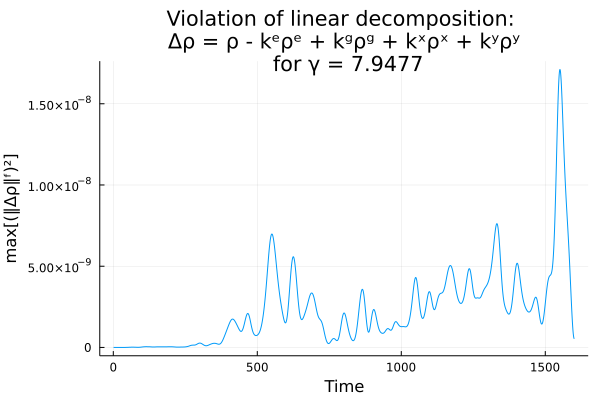

In [88]:
γᵢ = γ[7]
plt = plot(maximum(linearity_error(directory, γᵢ), dims=1), label="")
plt = title!("Violation of linear decomposition: \n Δρ = ρ - kᵉρᵉ + kᵍρᵍ + kˣρˣ + kʸρʸ \n for γ = "*γᵢ)
plt = xlabel!("Time")
plt = ylabel!("max[(‖Δρ‖ᶠ)²]")
savefig(plt, "lin_err_worst_gamma.png")
plt

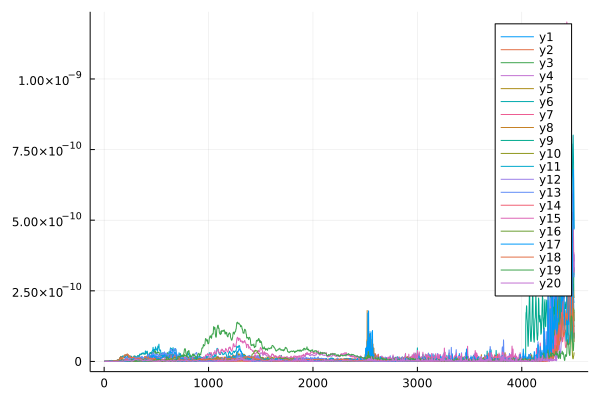

In [53]:
plot(linearity_error(directory, γ[2]))

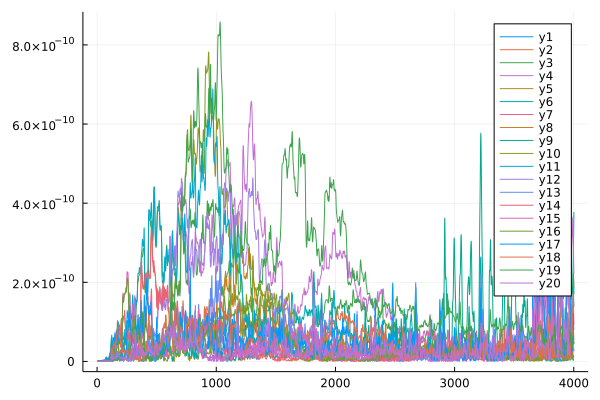

In [54]:
plot(linearity_error(directory, γ[3]))

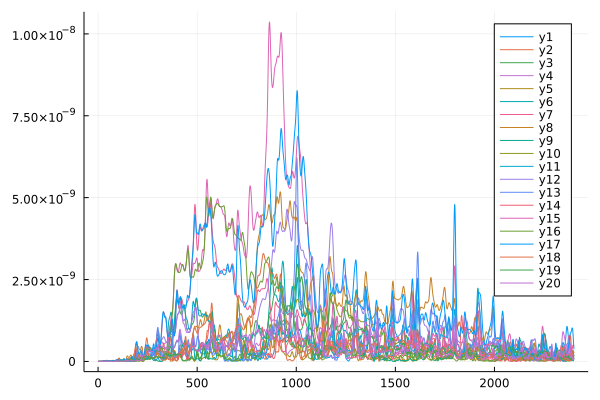

In [55]:
plot(linearity_error(directory, γ[4]))

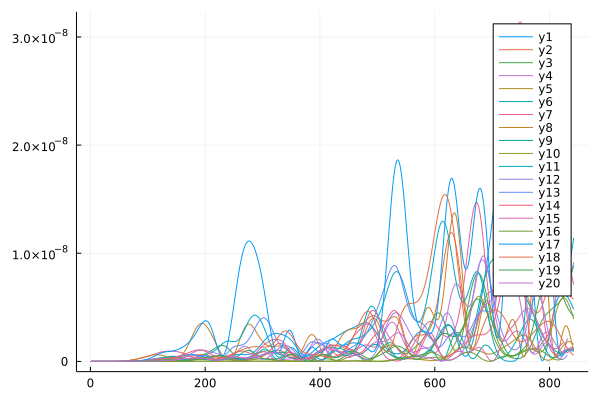

In [56]:
plot(linearity_error(directory, γ[5]))

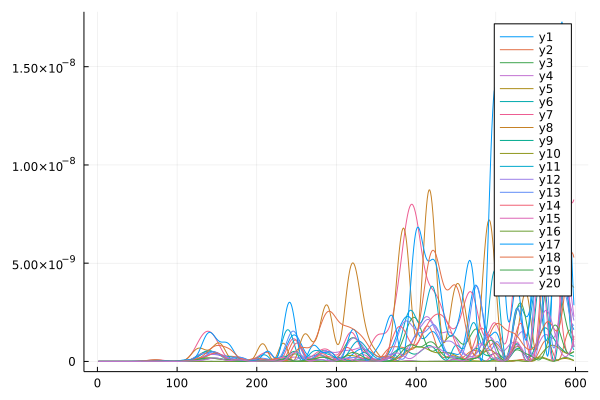

In [57]:
plot(linearity_error(directory, γ[6]))

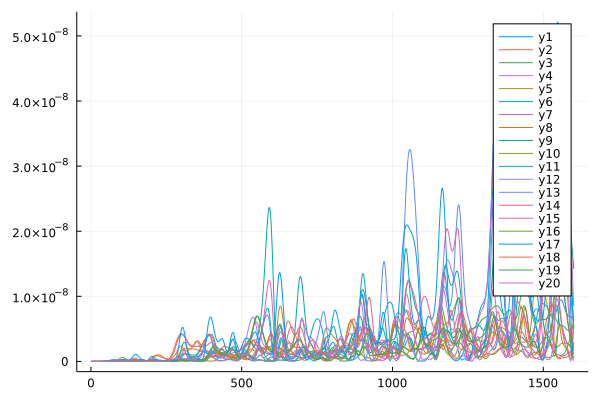

In [58]:
plot(linearity_error(directory, γ[7]))

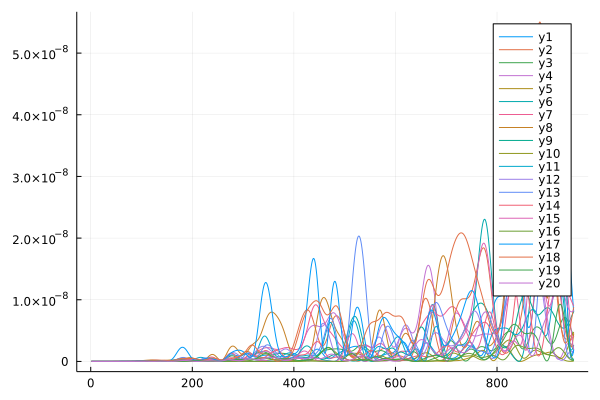

In [59]:
plot(linearity_error(directory, γ[8]))